# `Setup`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


### `Config`

In [5]:
MODEL_NAME = 'EfficientNetV2'

# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

### `Data Augmentation`

In [6]:
img_size_L = (168, 224)
img_size_M = (93, 124)
img_size_S = (48, 64)

# IMG Transformations
augmentations = {
    'train': v2.Compose([
    # v2.Grayscale(1),
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(img_size_M, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val_test': v2.Compose([
    # v2.Grayscale(1),
    v2.Resize(img_size_M, antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [7]:
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=augmentations['val_test'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val_test'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Lenght of train data: 15646
Lenght of val data: 3345
Lenght of val data: 3433


In [8]:
train_data.img_labels = train_data.img_labels
train_data.metadata.target.value_counts(True)

safe driving                    0.113511
talking on the phone - left     0.103924
texting - left                  0.103349
talking on the phone - right    0.102582
drinking                        0.102582
operating the radio             0.102263
texting - right                 0.101815
talking to passenger            0.092931
reaching behind                 0.092356
hair and makeup                 0.084686
Name: target, dtype: float64

In [9]:
val_data.img_labels = val_data.img_labels
val_data.img_labels.classname.value_counts(True)

c0    0.110314
c3    0.107025
c6    0.102840
c9    0.101943
c4    0.100448
c2    0.100149
c5    0.100149
c1    0.098954
c8    0.092975
c7    0.085202
Name: classname, dtype: float64

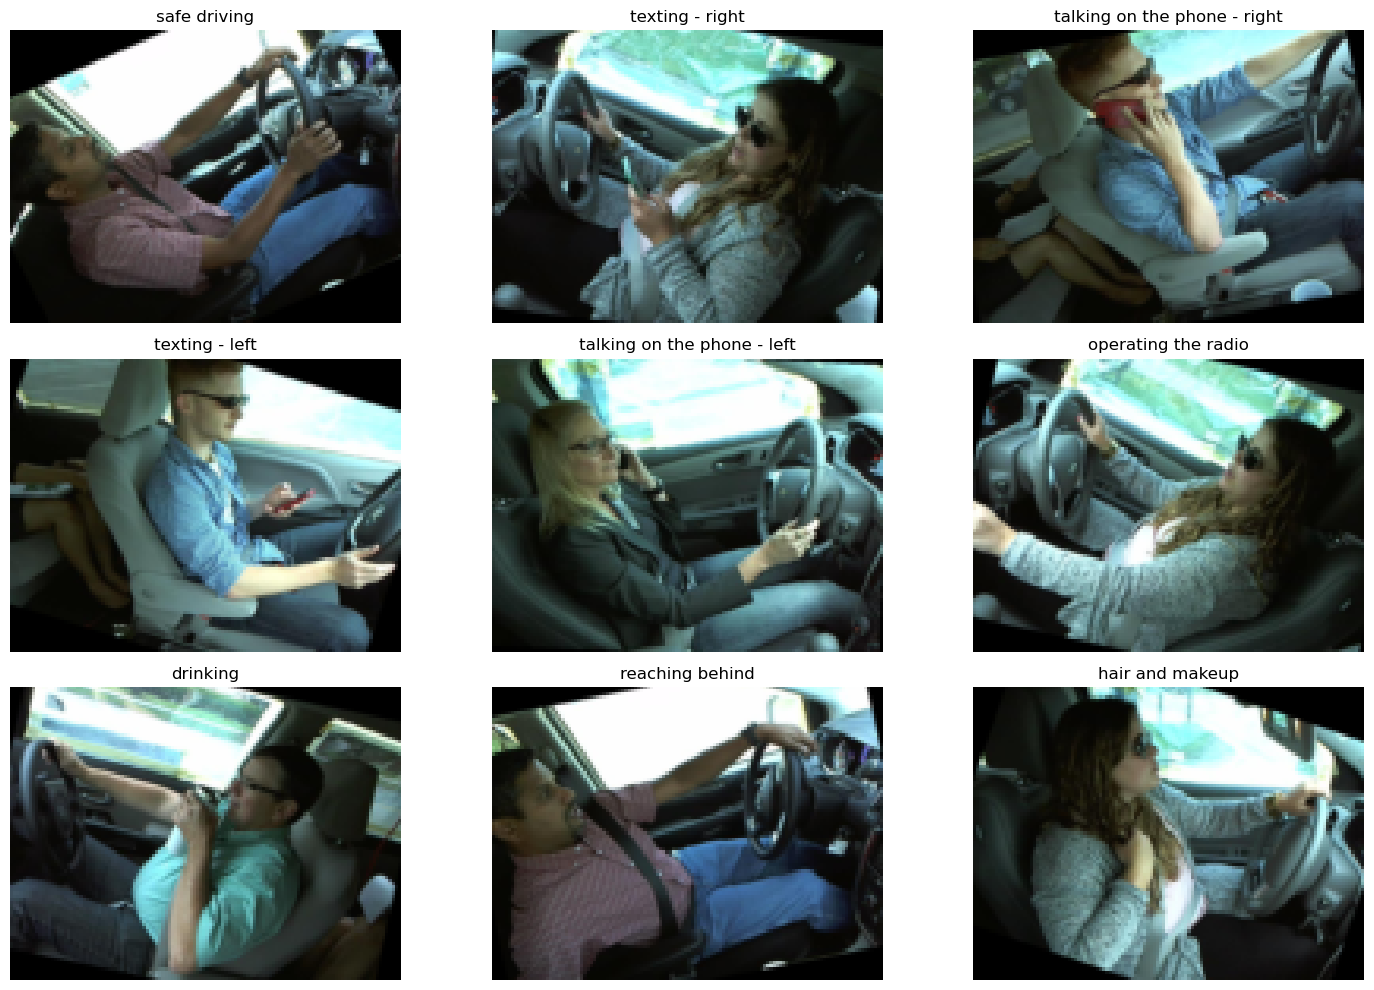

In [10]:
train_data.display_classes(id_to_class=True)

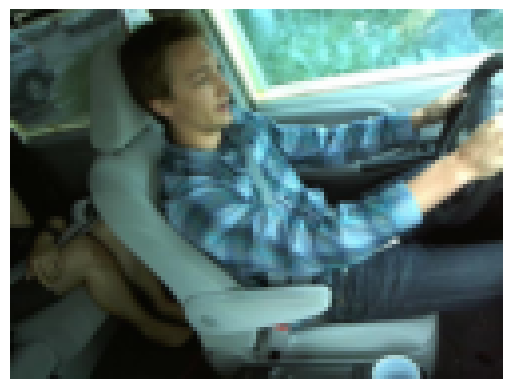

In [11]:
img, _ = val_data[100]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### `Model`

In [12]:
def Conv_3x3(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def Conv_1x1(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def SepConv_3x3(inp, oup): #input=32, output=16
    return nn.Sequential(
        # dw
        nn.Conv2d(inp, inp , 3, 1, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU6(inplace=True),
        # pw-linear
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, kernel):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        self.use_res_connect = self.stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # pw
            nn.Conv2d(inp, inp * expand_ratio, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU6(inplace=True),
            # dw
            nn.Conv2d(inp * expand_ratio, inp * expand_ratio, kernel, stride, kernel // 2, groups=inp * expand_ratio, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU6(inplace=True),
            # pw-linear
            nn.Conv2d(inp * expand_ratio, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MnasNet(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MnasNet, self).__init__()

        # setting of inverted residual blocks
        self.interverted_residual_setting = [
            # t, c, n, s, k
            [3, 24,  3, 2, 3],  # -> 56x56
            [3, 40,  3, 2, 5],  # -> 28x28
            [6, 80,  3, 2, 5],  # -> 14x14
            [6, 96,  2, 1, 3],  # -> 14x14
            [6, 192, 4, 2, 5],  # -> 7x7
            [6, 320, 1, 1, 3],  # -> 7x7
        ]

        assert input_size % 32 == 0
        input_channel = int(32 * width_mult)
        self.last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280

        # building first two layer
        self.features = [Conv_3x3(3, input_channel, 2), SepConv_3x3(input_channel, 16)]
        input_channel = 16

        # building inverted residual blocks (MBConv)
        for t, c, n, s, k in self.interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(InvertedResidual(input_channel, output_channel, s, t, k))
                else:
                    self.features.append(InvertedResidual(input_channel, output_channel, 1, t, k))
                input_channel = output_channel

        # building last several layers
        self.features.append(Conv_1x1(input_channel, self.last_channel))
        self.features.append(nn.AdaptiveAvgPool2d(1))

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.last_channel)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


if __name__ == '__main__':
    net = MnasNet()
    x_image = Variable(torch.randn(1, 3, 224, 224))
    y = net(x_image)
    # print(y)

In [15]:
# Model summary
model = MnasNet(10)
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
MnasNet                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 1280, 1, 1]          --
│    └─Sequential: 2-1                   [32, 32, 47, 62]          --
│    │    └─Conv2d: 3-1                  [32, 32, 47, 62]          864
│    │    └─BatchNorm2d: 3-2             [32, 32, 47, 62]          64
│    │    └─ReLU6: 3-3                   [32, 32, 47, 62]          --
│    └─Sequential: 2-2                   [32, 16, 47, 62]          --
│    │    └─Conv2d: 3-4                  [32, 32, 47, 62]          288
│    │    └─BatchNorm2d: 3-5             [32, 32, 47, 62]          64
│    │    └─ReLU6: 3-6                   [32, 32, 47, 62]          --
│    │    └─Conv2d: 3-7                  [32, 16, 47, 62]          512
│    │    └─BatchNorm2d: 3-8             [32, 16, 47, 62]          32
│    └─InvertedResidual: 2-3             [32, 24, 24, 31]          --
│    │    └─

#### `Training Methods`

In [16]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [17]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [18]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [19]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [20]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [35]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

### `Model Training`

In [34]:
MODEL_NAME

'EfficientNetV2'


Epoch 1 of 50 started...
Epoch 1 of 50 (4:21) - Train loss: 2.00316 - Train acc: 0.23751 - Val loss: 2.12221 - Val acc: 0.15670
Saving model with new best val_loss: 2.12221

Epoch 2 of 50 started...
Epoch 2 of 50 (3:54) - Train loss: 1.22544 - Train acc: 0.54011 - Val loss: 1.72377 - Val acc: 0.45509
Saving model with new best val_loss: 1.72377

Epoch 3 of 50 started...
Epoch 3 of 50 (4:34) - Train loss: 0.75716 - Train acc: 0.73246 - Val loss: 1.44288 - Val acc: 0.57269
Saving model with new best val_loss: 1.44288

Epoch 4 of 50 started...
Epoch 4 of 50 (4:6) - Train loss: 0.53136 - Train acc: 0.81920 - Val loss: 1.38647 - Val acc: 0.57948
Saving model with new best val_loss: 1.38647

Epoch 5 of 50 started...
Epoch 5 of 50 (3:59) - Train loss: 0.40986 - Train acc: 0.86515 - Val loss: 1.07472 - Val acc: 0.66027
Saving model with new best val_loss: 1.07472


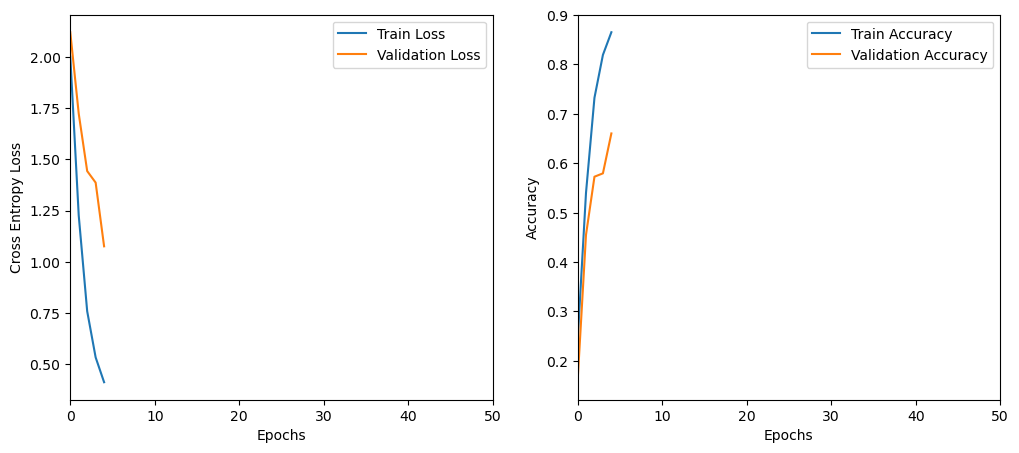


Epoch 6 of 50 started...
Epoch 6 of 50 (3:58) - Train loss: 0.33818 - Train acc: 0.89345 - Val loss: 2.50474 - Val acc: 0.42554
Early Stopping Counter 1 of 5

Epoch 7 of 50 started...
Epoch 7 of 50 (4:3) - Train loss: 0.28983 - Train acc: 0.90912 - Val loss: 1.90713 - Val acc: 0.53639
Early Stopping Counter 2 of 5

Epoch 8 of 50 started...
Epoch 8 of 50 (4:12) - Train loss: 0.25021 - Train acc: 0.92349 - Val loss: 1.86467 - Val acc: 0.54556
Early Stopping Counter 3 of 5

Epoch 9 of 50 started...
Epoch 9 of 50 (3:57) - Train loss: 0.22305 - Train acc: 0.93200 - Val loss: 2.05696 - Val acc: 0.55363
Early Stopping Counter 4 of 5

Epoch 10 of 50 started...
Epoch 10 of 50 (3:55) - Train loss: 0.20260 - Train acc: 0.94119 - Val loss: 1.45332 - Val acc: 0.62915


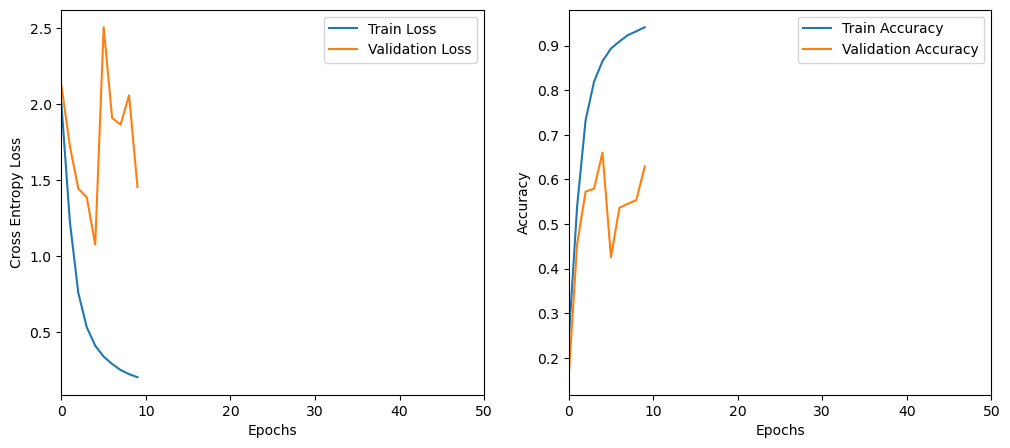

Early Stopping Counter 5 of 5
Epoch 10 of 50 - Early stopping
Saving final model, with loss:  1.4533159914943907


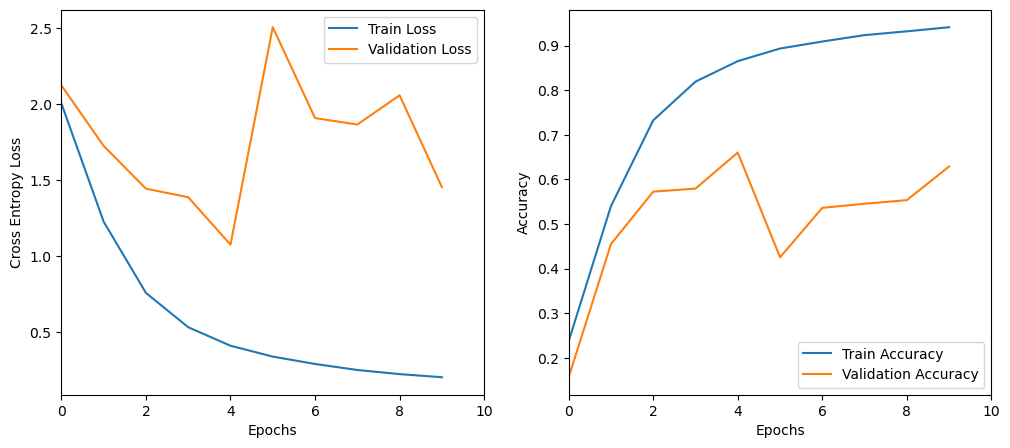

Total training time: 40:59


In [22]:
# Initialize MnasNet model
torch.manual_seed(42)
epochs = 50
model = MnasNet(10)
model = model.to(device) # Load model to device.
MODEL_NAME = 'MnasNET'

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# Setup scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                        'min',
#                                                        factor=.1,
#                                                        patience=5,
#                                                        min_lr=1e-7,
#                                                        verbose=True)

# Setup early stopping with a minimum delta of 1.5 - which means if val loss - training loss > min delta, add to counter
early_stopping = EarlyStopper(patience=5, min_delta=.03)

# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=None,
                early_stopping=early_stopping,
                model_name=MODEL_NAME)

### Testing on Test Images

In [23]:
 from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [25]:
def test_loop(model, dataloader, device):
    """test loop"""
    # Setup validation loss and accuracy
    test_acc = 0
    output_pred = [] 
    output_lab = [] 
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            output_pred.append(prediction)
            output_lab.append(labels)
            
            # Update validation accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    
    # Return validation loss and accuracy
    #print(f'Test Accuracy: {test_acc / len(dataloader)}')
    return test_acc / len(dataloader), output_lab, output_pred

In [27]:
test_acc, test_lab, test_pred = test_loop(model, val_dataloader, device)

In [39]:
# Best model
best_model = MnasNet(10) 
best_model.load_state_dict(torch.load('/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu/outputs/MnasNet/MnasNet_20231201_083505_best.pt'))
best_model.to(device)

best_acc, best_lab, best_pred = test_loop(best_model, val_dataloader, device)

In [40]:
print(f'Test Accuracy Last Model:', test_acc)
print(f'Test Accuracy Best Model:', best_acc)

Test Accuracy Last Model: 0.5370798320997329
Test Accuracy Best Model: 0.5471638656797864


In [29]:
# Label unpacking
labels = []
for x in test_lab:
    labels += list(x.cpu().numpy())
labels = np.array(labels)


# pred unpacking
pred = []
for x in test_pred:
    pred += list(x.argmax(axis=1).cpu().numpy())
pred = np.array(pred)

In [30]:
labels_to_class = lambda input: np.array([train_data.id_to_class[f'c{x}'] for x in input])


In [31]:
label_classes = labels_to_class(labels)
pred_classes = labels_to_class(pred)

In [32]:
np.unique(label_classes)

array(['drinking', 'hair and makeup', 'operating the radio',
       'reaching behind', 'safe driving', 'talking on the phone - left',
       'talking on the phone - right', 'talking to passenger',
       'texting - left', 'texting - right'], dtype='<U28')

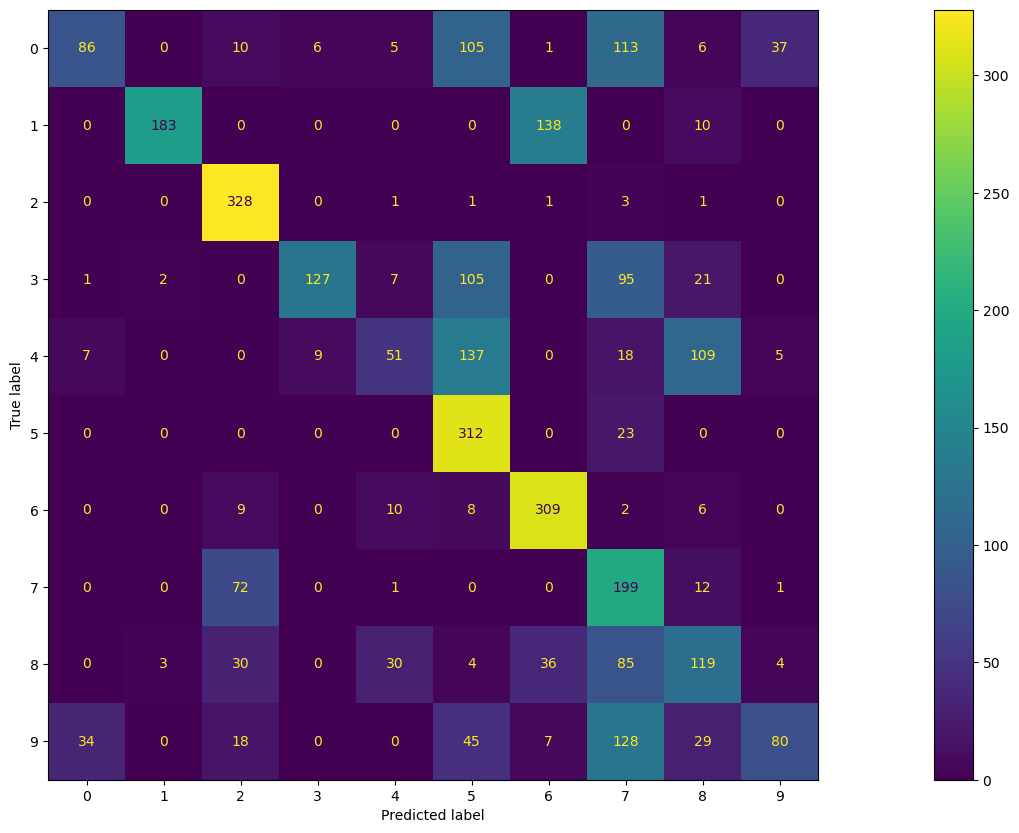

In [33]:
fig, axs = plt.subplots(figsize=(30,10))
cm = confusion_matrix(labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs)


In [227]:
train_data.id_to_class

{'c0': 'safe driving',
 'c1': 'texting - right',
 'c2': 'talking on the phone - right',
 'c3': 'texting - left',
 'c4': 'talking on the phone - left',
 'c5': 'operating the radio',
 'c6': 'drinking',
 'c7': 'reaching behind',
 'c8': 'hair and makeup',
 'c9': 'talking to passenger'}